In [1]:
import os
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from itertools import product
import pickle
import scipy.io as sio
import glob

import torch
import torchvision

from bdpy.dataform import Features
from bdpy.distcomp import DistComp
from bdpy.stats.corr import corrcoef, corrmat
from bdpy.fig import makefigure, draw_footnote, box_off


sys.path.append('/home/shirakawa/movie/pytorch_iCNN/icnn_torch')
from utils import normalise_img, img_preprocess,normalise_vid, vid_preprocess, get_cnn_features, load_video, save_video, save_gif,create_feature_masks, clip_extreme_value
sys.path.append('/home/shirakawa/kspy/bdpy3')
from tile_images import  tile_videos_v2 as tile_videos
sys.path.append('/home/shirakawa/kspy/stimulus_evaluation')
from stimeval import VideoEvaluator

In [2]:
def normalise_vid(vid, opt = 'channelwise'):
    '''Normalize the image.
    Map the minimum pixel to 0; map the maximum pixel to 255.
    Convert the pixels to be int
    '''
    if opt == 'normal':
    
        vid = vid - vid.min()
        if vid.max() > 0:
            vid = vid * (255.0 /vid.max())
    elif opt == 'channelwise':
        rgb_num = vid.shape[-1]
        for vc in range(rgb_num):
            tmp_ch_vid = vid[...,vc] 
            tmp_ch_vid = tmp_ch_vid - tmp_ch_vid.min()
            if tmp_ch_vid.max() > 0:
                vid[...,vc] = tmp_ch_vid * (255.0 /tmp_ch_vid.max())
            
    vid = np.uint8(vid)
    return vid

In [38]:
res_dir_list = [
    'Recon_vid_from_recon_img_and_recon_video',
    'Recon_vid_from_recon_img_and_true_video',
    'Recon_vid_from_true_img_and_true_video'
]


save_dir = 'result_video'
save_frame_dir =  'result_video/frame'
os.makedirs(save_frame_dir, exist_ok=True)

pretrained_list = ['vox-256', 'fashion-256', 'mgif-256', 'bair-256', 'taichi-256']

true_image_path = "/home/shirakawa/movie/data/contents_shared/MITtest_v1/derivatives/frames/f0t90_224x224/"

true_video_path = "/home/shirakawa/movie/data/contents_shared/MITtest_v1/source/"

recon_image_path = "/home/shirakawa/movie/code/py3_bdata_analysis/python/feature-inversion/results/recon_decoded_feature/recon_img_from_MIT_decoded_feature_pytorch_DGN_various_model_optimizer_grad_norm/pytorch/VGG_ILSVRC_19_layers/KS_short_ave_tr2/VC_retiMTDVC/Adam/"

recon_video_path = "/home/shirakawa/movie/code/py3_bdata_analysis/python/feature-inversion/results/recon_decoded_feature/recon_short_vid_from_MotionNet_VGG_combine_feature_pytorch_equal_corrloss_static_input_gblur_201207/KS_short_ave_tr2/VC_retiMTDVC/Adam/"

In [59]:
show_video_id_list = [18, 19,  40,49 ]

In [55]:
res_dir  = res_dir_list[0]

In [56]:
true_video_path

'/home/shirakawa/movie/data/contents_shared/MITtest_v1/source/'

In [57]:
#load driving video
vid_id = show_vid_list[0]

#true_video_file = np.sort(os.listdir(true_video_path))[vid_id]
#true_video = load_video(os.path.join(true_video_path, true_video_file), 'int')


def load_video_from_true(video_path, video_id, video_len=90):
    true_video_file = np.sort(os.listdir(video_path))[video_id]
    true_video = load_video(os.path.join(video_path, true_video_file), 'int')[:video_len]
    return true_video


def load_video_from_recon(video_path, video_id, video_len=11):
    recon_video_dir = np.sort(os.listdir(video_path))[video_id]
    recon_video = sio.loadmat(os.path.join(video_path, recon_video_dir, 'no_correct', '0.5', 'recon.mat'))['recon_stim']
    recon_video_normalize = normalise_vid(clip_extreme_value(recon_video, pct=4))
    return recon_video_normalize



def load_image_from_true(image_path, image_id, video_len=11):
    true_image_dir = np.sort(os.listdir(image_path))[image_id]
    image_path = os.path.join(image_path, true_image_dir, 'image_0000.jpg')
    
    img = PIL.Image.open(image_path).resize([224,224])
    img_array = np.asarray(img)
    
    return np.tile(img_array, (video_len, 1,1,1))

def load_image_from_recon(image_path, image_id, video_len=11):
    image_path = np.sort(glob.glob(image_path + '/*.jpg'))[image_id]
    img = PIL.Image.open(image_path).resize([224,224])
    img_array = np.asarray(img)
    
    return np.tile(img_array, (video_len, 1,1,1))

def load_animated_video(res_dir, model_name, image_id):
    res_video_file = np.sort(os.listdir(os.path.join(res_dir, model_name)))[image_id]
    res_video = load_video(os.path.join(res_dir, model_name, res_video_file), 'int')
    return res_video

def load_animate_video_package(res_dir, image_id, model_name_list):
    
    res_dict = {}
    
    if res_dir == 'Recon_vid_from_recon_img_and_recon_video':
        video_len = 11
        driving_video = load_video_from_recon(recon_video_path, image_id, video_len)
        source_video = load_image_from_recon(recon_image_path, image_id, video_len)
        
    elif res_dir == 'Recon_vid_from_recon_img_and_true_video':
        video_len = 90
        driving_video = load_video_from_true(true_video_path, image_id, video_len )
        source_video = load_image_from_recon(recon_image_path, image_id, video_len)
        
    elif res_dir == 'Recon_vid_from_true_img_and_true_video':
        video_len = 90
        driving_video = load_video_from_true(true_video_path, image_id,video_len)
        source_video = load_image_from_true(true_image_path, image_id, video_len)
        
    else:
        print('note')
        
        
    res_dict['driving_video'] = driving_video
    res_dict['source_video'] = source_video
    
    #driving video
    for model_name in model_name_list:
        animated_video = load_animated_video(res_dir, model_name, image_id)
        res_dict[model_name] = animated_video
    return res_dict

Recon_vid_from_recon_img_and_recon_video-18
Recon_vid_from_recon_img_and_recon_video-18done
Recon_vid_from_recon_img_and_recon_video-19
Recon_vid_from_recon_img_and_recon_video-19done
Recon_vid_from_recon_img_and_recon_video-40
Recon_vid_from_recon_img_and_recon_video-40done
Recon_vid_from_recon_img_and_recon_video-49
Recon_vid_from_recon_img_and_recon_video-49done
Recon_vid_from_recon_img_and_true_video-18
Recon_vid_from_recon_img_and_true_video-18done
Recon_vid_from_recon_img_and_true_video-19
Recon_vid_from_recon_img_and_true_video-19done
Recon_vid_from_recon_img_and_true_video-40
Recon_vid_from_recon_img_and_true_video-40done
Recon_vid_from_recon_img_and_true_video-49
Recon_vid_from_recon_img_and_true_video-49done
Recon_vid_from_true_img_and_true_video-18
Recon_vid_from_true_img_and_true_video-18done
Recon_vid_from_true_img_and_true_video-19
Recon_vid_from_true_img_and_true_video-19done
Recon_vid_from_true_img_and_true_video-40
Recon_vid_from_true_img_and_true_video-40done
Recon_vi

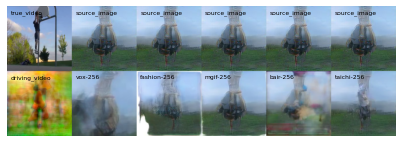

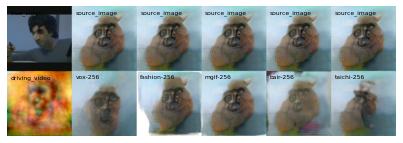

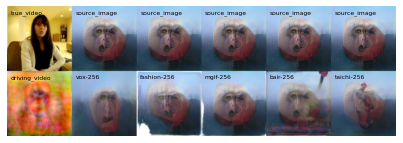

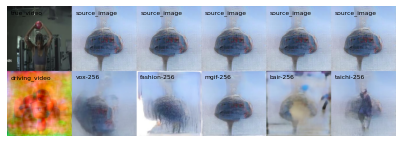

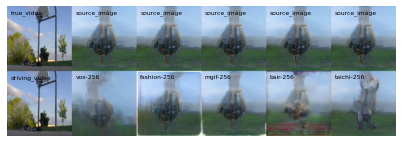

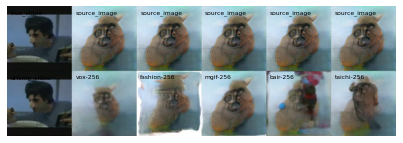

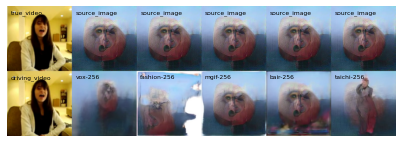

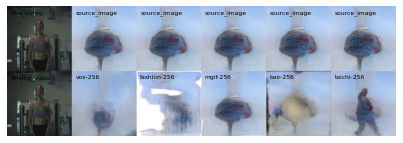

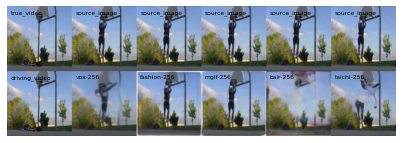

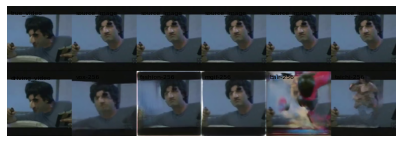

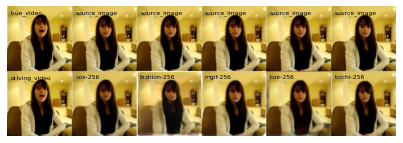

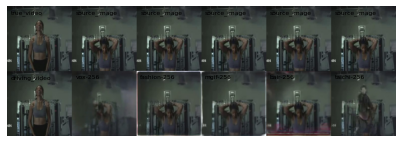

In [62]:
for res_dir, image_id in product(res_dir_list, show_video_id_list):
    print(f'{res_dir}-{image_id}')
    show_dict = load_animate_video_package(res_dir, image_id, pretrained_list)
    #append video
    video_len = len(show_dict['driving_video'])
    show_label_list =[]

    upper_row = list(load_video_from_true(true_video_path, image_id, video_len=video_len)[np.newaxis])#list(np.ones_like(show_dict['source_video'] * 255)[np.newaxis])
    show_label_list.append('true_video')
    for model_name in pretrained_list:
        upper_row += list(show_dict['source_video'][np.newaxis]) 
        show_label_list.append('source_image')

    bottom_row = list(show_dict['driving_video'][np.newaxis])
    show_label_list.append('driving_video')
    for model_name in pretrained_list:
        bottom_row += list(show_dict[model_name][np.newaxis])
        show_label_list.append(model_name)
    show_vid_list = upper_row + bottom_row
    
    
    shownum =2#len(show_stim_index)
    save_name = f'{res_dir}-{image_id}'
    fig = plt.figure(figsize= ( len(show_vid_list)/shownum,shownum, ))
    tile_videos(show_vid_list  ,save_base_name = save_name, labels =show_label_list,
                save_dir=save_dir,save_frame_dir=save_frame_dir,  fig =fig, label_fontsize=6,
                dpi=150, ncols = len(show_vid_list)//shownum, fr_rate= 16)
    print(save_name + 'done')


In [24]:
res_dir

'Recon_vid_from_recon_img_and_recon_video'

In [25]:
image_id = 19
show_dict = load_animate_video_package(res_dir_list[1], image_id, pretrained_list)

In [26]:
upper_row = list(show_dict['source_video']) * len(pretrained_list)

In [27]:
show_label_list =[]

upper_row = list(np.ones_like(show_dict['source_video'] + 255)[np.newaxis])
show_label_list.append('')
for model_name in pretrained_list:
    upper_row += list(show_dict['source_video'][np.newaxis]) 
    show_label_list.append('source_image')

bottom_row = list(show_dict['driving_video'][np.newaxis])
show_label_list.append('driving_video')
for model_name in pretrained_list:
    bottom_row += list(show_dict[model_name][np.newaxis])
    show_label_list.append(model_name)
show_vid_list = upper_row + bottom_row

In [28]:
len(show_vid_list)

12

In [29]:
show_vid_list[7].shape

(90, 224, 224, 3)

animated_image19done


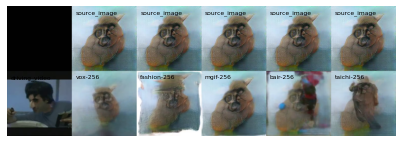

In [31]:

shownum =2#len(show_stim_index)
save_name = f'animated_image{image_id}'
fig = plt.figure(figsize= ( len(show_vid_list)/shownum,shownum, ))
tile_videos(show_vid_list  ,save_base_name = save_name, labels =show_label_list,
            save_dir=save_dir,save_frame_dir=save_frame_dir,  fig =fig, label_fontsize=6,
            dpi=150, ncols = len(show_vid_list)//shownum,)
print(save_name + 'done')

In [137]:
len(upper_row)

6

In [60]:
im = load_image_from_true(true_image_path, 18)

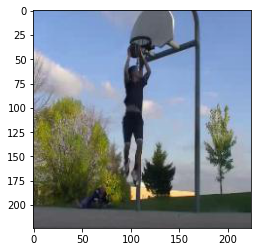

In [66]:
plt.imshow(im[2])

In [58]:
np.tile(im, (16, 1,1,1))

(16, 224, 224, 3)

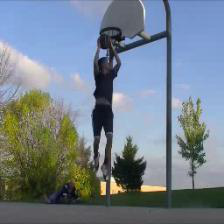

In [39]:
PIL.Image.open(os.path.join(true_image_path,np.sort(os.listdir(true_image_path))[18],'image_0000.jpg',))

In [9]:
ee = sio.loadmat(os.path.join(recon_video_path, recon_video_file, 'no_correct', '0.5', 'recon.mat'))['recon_stim']

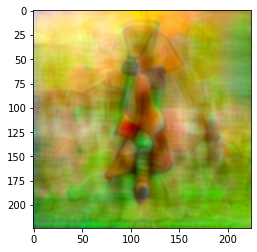

In [11]:
plt.imshow(normalise_vid(clip_extreme_value(ee, pct=4))[0])

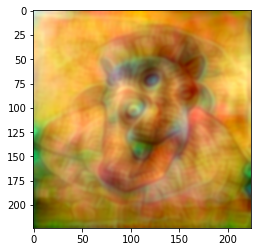

In [34]:
plt.imshow(load_video_from_recon(recon_video_path, 19)[0])

In [19]:
load_video_from_true(true_video_path, 19)

array([[[[15, 17, 14],
         [15, 17, 14],
         [15, 17, 14],
         ...,
         [14, 16, 16],
         [14, 16, 16],
         [14, 16, 16]],

        [[15, 17, 14],
         [15, 17, 14],
         [15, 17, 14],
         ...,
         [14, 16, 16],
         [14, 16, 16],
         [14, 16, 16]],

        [[15, 17, 14],
         [15, 17, 14],
         [15, 17, 14],
         ...,
         [14, 16, 16],
         [14, 16, 16],
         [14, 16, 16]],

        ...,

        [[14, 16, 13],
         [14, 16, 13],
         [14, 16, 13],
         ...,
         [13, 15, 12],
         [13, 15, 12],
         [13, 15, 12]],

        [[10, 12,  9],
         [10, 12,  9],
         [10, 12,  9],
         ...,
         [ 9, 11,  8],
         [ 9, 11,  8],
         [ 9, 11,  8]],

        [[ 7,  9,  6],
         [ 7,  9,  6],
         [ 7,  9,  6],
         ...,
         [ 6,  8,  5],
         [ 6,  8,  5],
         [ 6,  8,  5]]],


       [[[15, 17, 14],
         [15, 17, 14],
         [15, 

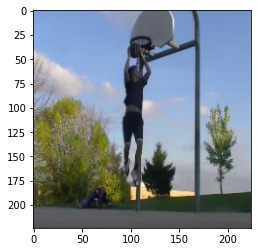

In [23]:
plt.imshow(true_video[0])

In [10]:
os.listdir(res_dir)

['00.mp4',
 '01.mp4',
 '02.mp4',
 '03.mp4',
 '04.mp4',
 '05.mp4',
 '06.mp4',
 '07.mp4',
 '08.mp4',
 '09.mp4',
 '10.mp4',
 '11.mp4',
 '12.mp4',
 '13.mp4',
 '14.mp4',
 '15.mp4',
 '16.mp4',
 '17.mp4',
 '18.mp4',
 '19.mp4',
 '20.mp4',
 '21.mp4',
 '22.mp4',
 '23.mp4',
 '24.mp4',
 '25.mp4',
 '26.mp4',
 '27.mp4',
 '28.mp4',
 '29.mp4',
 '30.mp4',
 '31.mp4',
 '32.mp4',
 '33.mp4',
 '34.mp4',
 '35.mp4',
 '36.mp4',
 '37.mp4',
 '38.mp4',
 '39.mp4',
 '40.mp4',
 '41.mp4',
 '42.mp4',
 '43.mp4',
 '44.mp4',
 '45.mp4',
 '46.mp4',
 '47.mp4',
 '48.mp4',
 '49.mp4',
 '50.mp4',
 'taichi-256',
 'bair-256',
 'fashion-256',
 'mgif-256',
 'vox-adv-256',
 'vox-256']